In [57]:
!pip install pandas
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install mutagen
!pip install pillow

In [58]:
!pip install matplotlib==3.7.0 --user

In [91]:
import os
import time
import librosa
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import tensorflow_hub as hub

# Data Processing

In [60]:
!pip install pandas
!pip install torchsummary

In [62]:
import os
os.chdir("C:/Users/Asus/OneDrive/Desktop/DE/2B/Urban_Dataset_8k/UrbanSound8k")

In [63]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 5EF7-DDA7

 Directory of C:\Users\Asus\OneDrive\Desktop\DE\2B\Urban_Dataset_8k\UrbanSound8K

10-04-2024  14:06    <DIR>          .
10-04-2024  14:12    <DIR>          ..
20-05-2014  00:28            15,364 .DS_Store
20-05-2014  00:31         1,411,258 203929-7-2-9.wav
20-05-2014  00:42           162,332 4918-3-4-0.wav
10-04-2024  14:06    <DIR>          audio
20-05-2014  00:42           162,332 Dog_Bark_1.wav
20-05-2014  00:41           475,844 Dog_Bark_2.wav
20-05-2014  00:34           768,044 Drilling_!.wav
20-05-2014  00:41         2,304,080 Engine_Idling_1.wav
20-05-2014  00:45            26,155 FREESOUNDCREDITS.txt
09-11-2023  14:56           270,348 gun-gunshot-01.wav
09-11-2023  14:55           283,396 gun-gunshot-02.wav
18-05-2022  14:08           261,570 gun-shot-fx_77bpm_D_minor.wav
14-06-2023  06:07           352,918 high-quality-gunshot-sfx.wav
10-04-2024  14:06    <DIR>          metadata
10-04-2024  14:06    <DIR>          

# Data Analysis
We will perform a set of data analysis steps to observe and see patterns in the data given and choose the best modeling accordingly.


## Data Statistics

In [73]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [74]:
dataset_df = create_dataset_df("C:/Users/Asus/OneDrive/Desktop/DE/2B/Urban_Dataset_8k/UrbanSound8K/metadata/UrbanSound8K.csv")
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,audio\fold5\100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,audio\fold5\100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,audio\fold5\100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,audio\fold5\100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,audio\fold5\100263-2-0-137.wav


In [75]:
dataset_df.groupby('class').slice_file_name.count()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

We can observe all the classes except car_horn, gun_shot and siren have 1000 samples. We could explore options to include **class weights** in the loss function or **oversampling** if we see that the under-represented classes are not being classified as well as the rest.

In [76]:
def get_audio_metadata_mutagen(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata 

In [77]:
def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []} 
    # Extract metadata
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # Add new columns to dataframe
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]
    
    return dataset_df

In [78]:
dataset_df = dataset_df.drop(columns=['fold', 'slice_file_name', 'fsID', 'start', 'end'])

In [79]:
!chdir

C:\Users\Asus\OneDrive\Desktop\DE\2B\Urban_Dataset_8k\UrbanSound8K


In [80]:
audio_statistics_df = compute_audio_statistics(dataset_df)

In [81]:
audio_statistics_df.describe()

,salience,classID,length,bitrate,channels,sample_rate,bits_per_sample
count,8732.000000,8732.000000,8732.000000,8.732000e+03,8732.000000,8732.000000,8732.000000
mean,1.347000,4.592877,3.603644,1.800775e+06,1.915369,48456.979272,18.780119
std,0.476043,2.894544,0.980913,9.765852e+05,0.278348,15300.080707,4.227168
min,1.000000,0.000000,0.000816,4.409600e+04,1.000000,8000.000000,4.000000
25%,1.000000,2.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
50%,1.000000,4.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
75%,2.000000,7.000000,4.000000,2.116800e+06,2.000000,48000.000000,24.000000
max,2.000000,9.000000,4.000000,1.228800e+07,2.000000,192000.000000,32.000000


We can observe in the following tables that the data has been recorded and digitalized in different ways.

* It has been mostly recorded using **2 channels in almost all the samples (stereo)**.
* The sample rates go from **8kHz to 192kHz (mostly 44kHz, 48Khz)**
* The length of the audios goes from **0.0008s to 4s (mostly 4s)**
* The bits per sample used go from **4 to 32 (mostly 24 bits)**
* The data will need to be standardized before to be fed to a machine learning model.

In [82]:
audio_statistics_df['sample_rate'].value_counts(), audio_statistics_df['bits_per_sample'].value_counts()

(sample_rate
 44100     5370
 48000     2502
 96000      610
 24000       82
 16000       45
 22050       44
 11025       39
 192000      17
 8000        12
 11024        7
 32000        4
 Name: count, dtype: int64,
 bits_per_sample
 16    5758
 24    2753
 32     169
 8       43
 4        9
 Name: count, dtype: int64)

If we now look at the audio statistics per each of the different labels we see that:

* The length of the audios for the classes 1 and 6 is much smaller than for the rest of classes. Could be used as a feature if we wanted.

* The rest of metadata is very similar for every class, can't see any trend.

In [83]:
audio_statistics_df.groupby('class').describe()

salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                 classID       ... sample_rate           bits_per_sample  \
                   count mean  ...         75%       max           count   
class                          ...                                         
air_conditioner   1000.0  0.0  ...     48000.0   48000.0          1000.0   
car_horn           429.0  1.0  ...     48000.0   96000.0           429.0   
children_playing  1000.0  2.0  ...     48000.0   96000.0          1000.0   
dog_bark          1000.0  3.0  ...     48000.0   96000.0          1000.0   
drilling          1000.0  4.0  ...     44100.0  192000.0          1000.0   
engine_idling     1000.0  5.0  ...     48000.0   96000.0          1000.0   
gun_shot           374.0  6.0  ...     48000.0   96000.0           374.0   
jackhammer        1000.0  7.0  ...     48000.0   96000.0          1000.0   
siren              929.0  8.0  ...     48000.0   48000.0           929.0   
street_music      1000.0  9.0  ...     44100.0   96000.0          1000.0   

                                                                     
                       mean       std   min   25%   50%   75%   max  
class                                                                
air_conditioner   19.584000  4.393432  16.0  16.0  16.0  24.0  32.0  
car_horn          17.641026  3.280044  16.0  16.0  16.0  16.0  32.0  
children_playing  18.964000  4.077171   4.0  16.0  16.0  24.0  24.0  
dog_bark          18.288000  3.939108  16.0  16.0  16.0  24.0  32.0  
drilling          18.180000  4.235273   4.0  16.0  16.0  24.0  32.0  
engine_idling     19.688000  4.459882  16.0  16.0  16.0  24.0  32.0  
gun_shot          18.331551  3.640290  16.0  16.0  16.0  24.0  24.0  
jackhammer        20.044000  5.047727   4.0  16.0  16.0  24.0  32.0  
siren             17.550054  3.630558   8.0  16.0  16.0  16.0  32.0  
street_music      18.512000  3.714789  16.0  16.0  16.0  24.0  24.0  

[10 rows x 56 columns]

## Data Visualization
As the data consists of Audio files we will use the `Librosa` library to load, plot and perform audio processing.

We will use the `IPython.display.Audio` package to listen the files directly in the Jupyter Notebook.

### Waveform

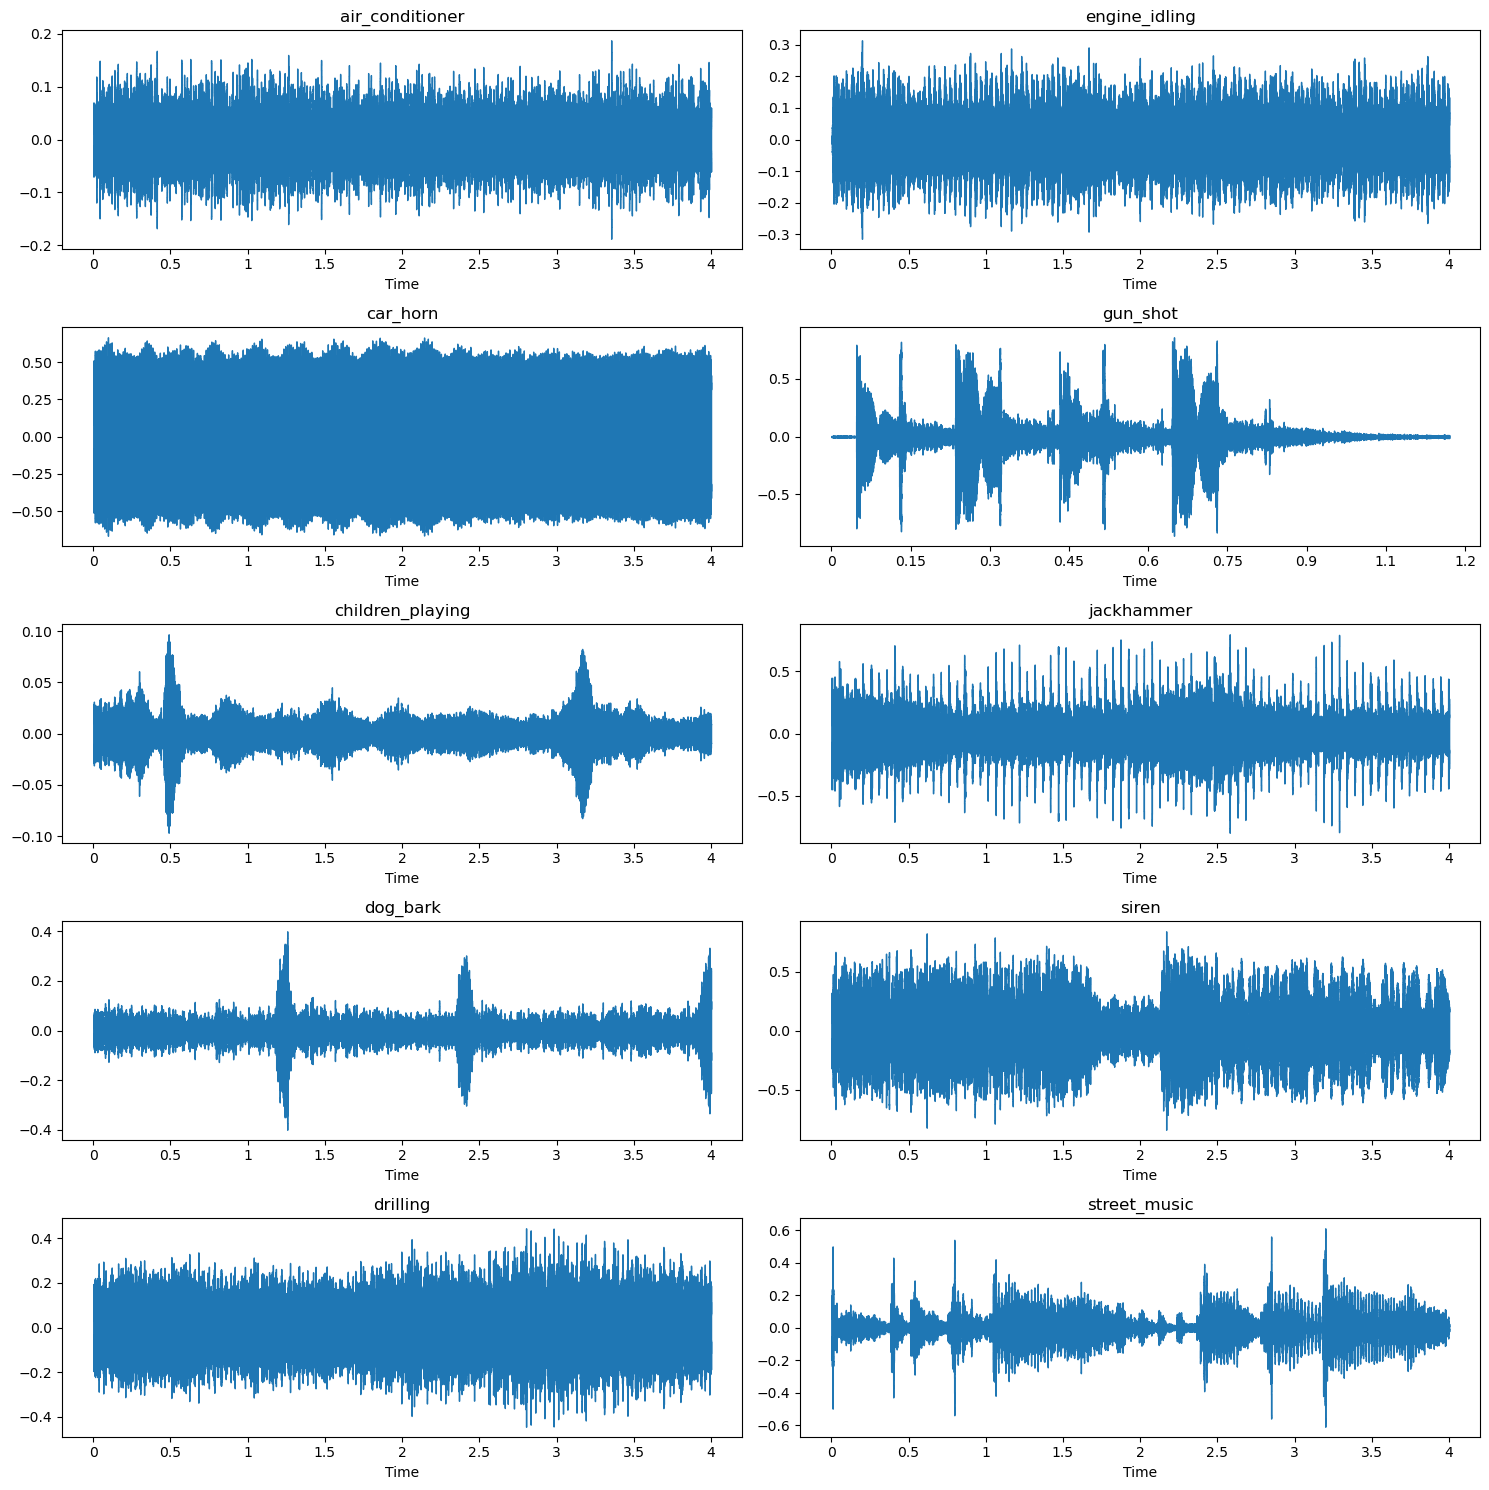

In [102]:
# Randomly select one sample of each class
random_samples = dataset_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_data, sample_rate = librosa.load(audio_samples[index])
        librosa.display.waveshow(audio_data, sr= sample_rate, ax=axs[row][col], color='tab:blue')
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()
plt.savefig("Waveforms_Dataset.png", bbox_inches = "tight", dpi=800)

### STFT (y axis)

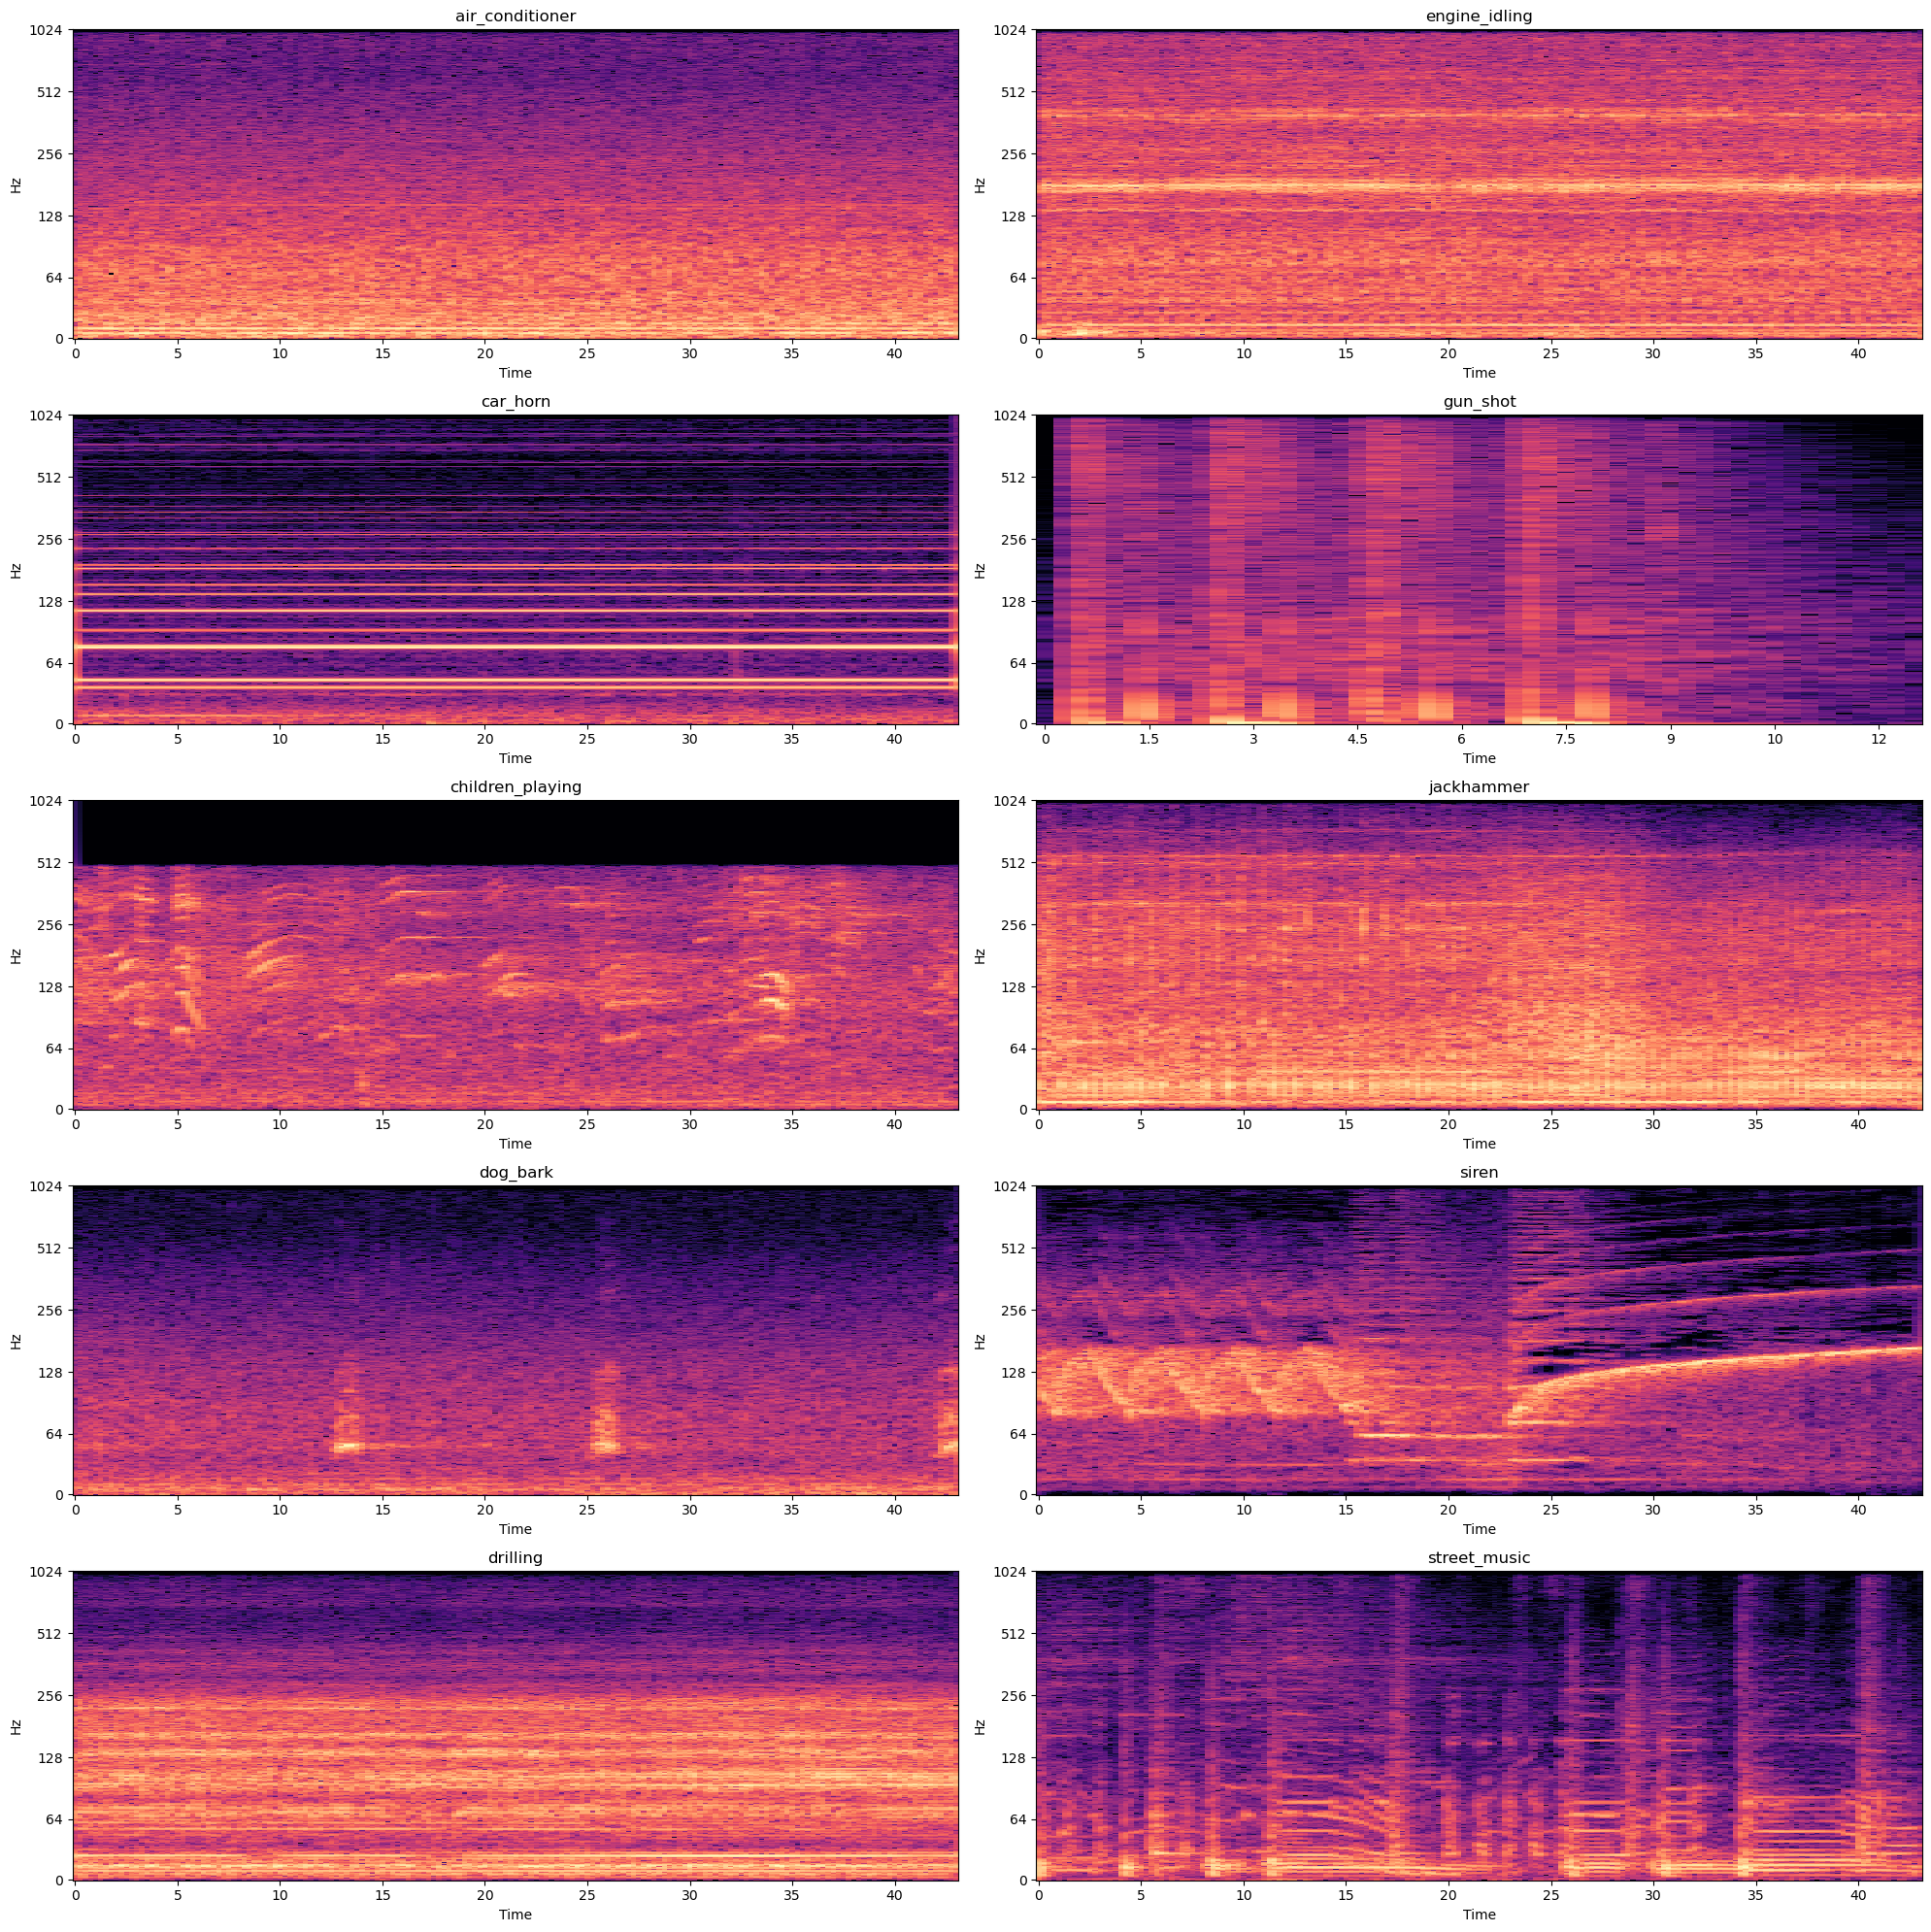

In [108]:
# Visualize the STFT
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(S_db, 
                             sr=n_fft, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis='log',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()
plt.savefig("STFT_Dataset.png", bbox_inches = "tight", dpi=800)

### Mel-Spectogram

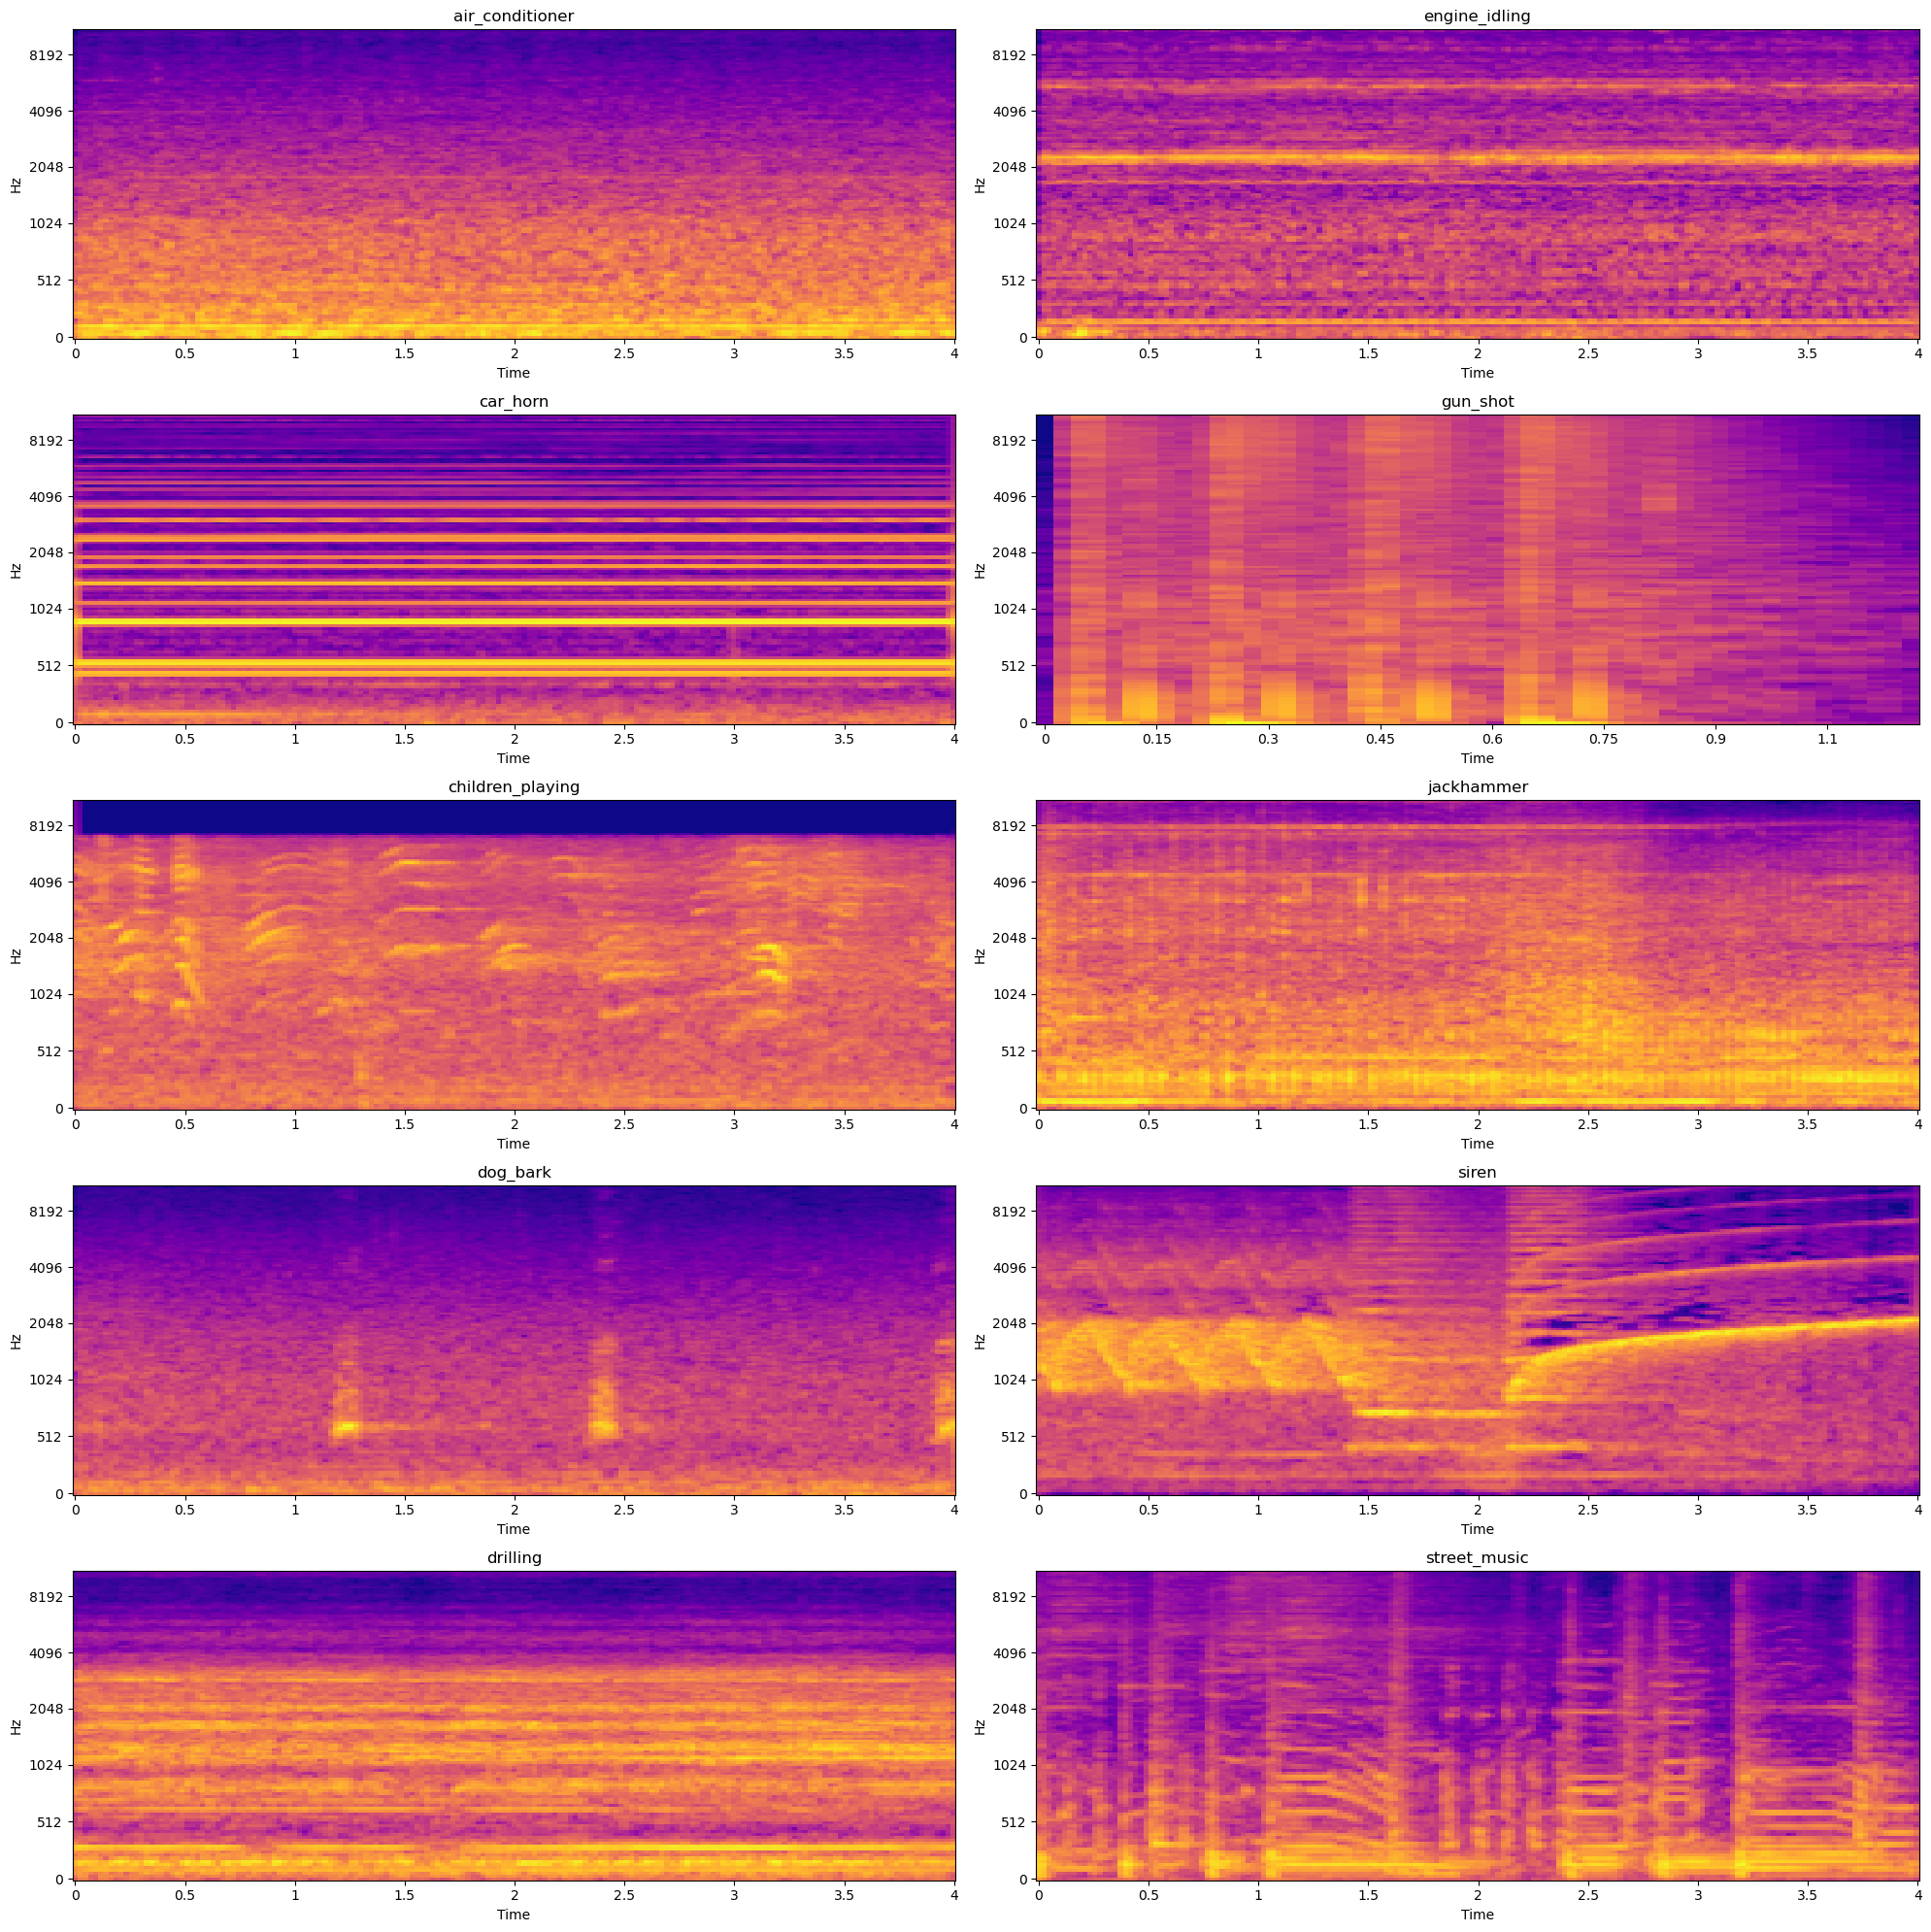

In [116]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Visualize the Mel-Spectograms
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio_file,
            sr=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=128,  # Number of Mel bands
            fmax=8000,   # Maximum frequency
        )
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        librosa.display.specshow(
            mel_spectrogram_db,
            sr=sample_rate,
            hop_length=hop_length,
            x_axis="time",
            y_axis="mel",
            ax=axs[row][col], cmap = 'plasma'
        )
        axs[row][col].set_title("{}".format(labels[index]))
        index += 1
fig.tight_layout()
plt.savefig("MelSpec_Dataset.png", bbox_inches="tight", dpi=800)


In [ ]:
# Listen to the recordings (index can be changed to listen to a different recording)
index = 9
print('Listen to {} sample'.format(labels[index]))
IPython.display.Audio(audio_samples[index])

In [ ]:
audio_file, sample_rate = librosa.load(audio_samples[0])
stft = librosa.stft(audio_file)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
print(S_db.shape)
S_db

### MFCCs

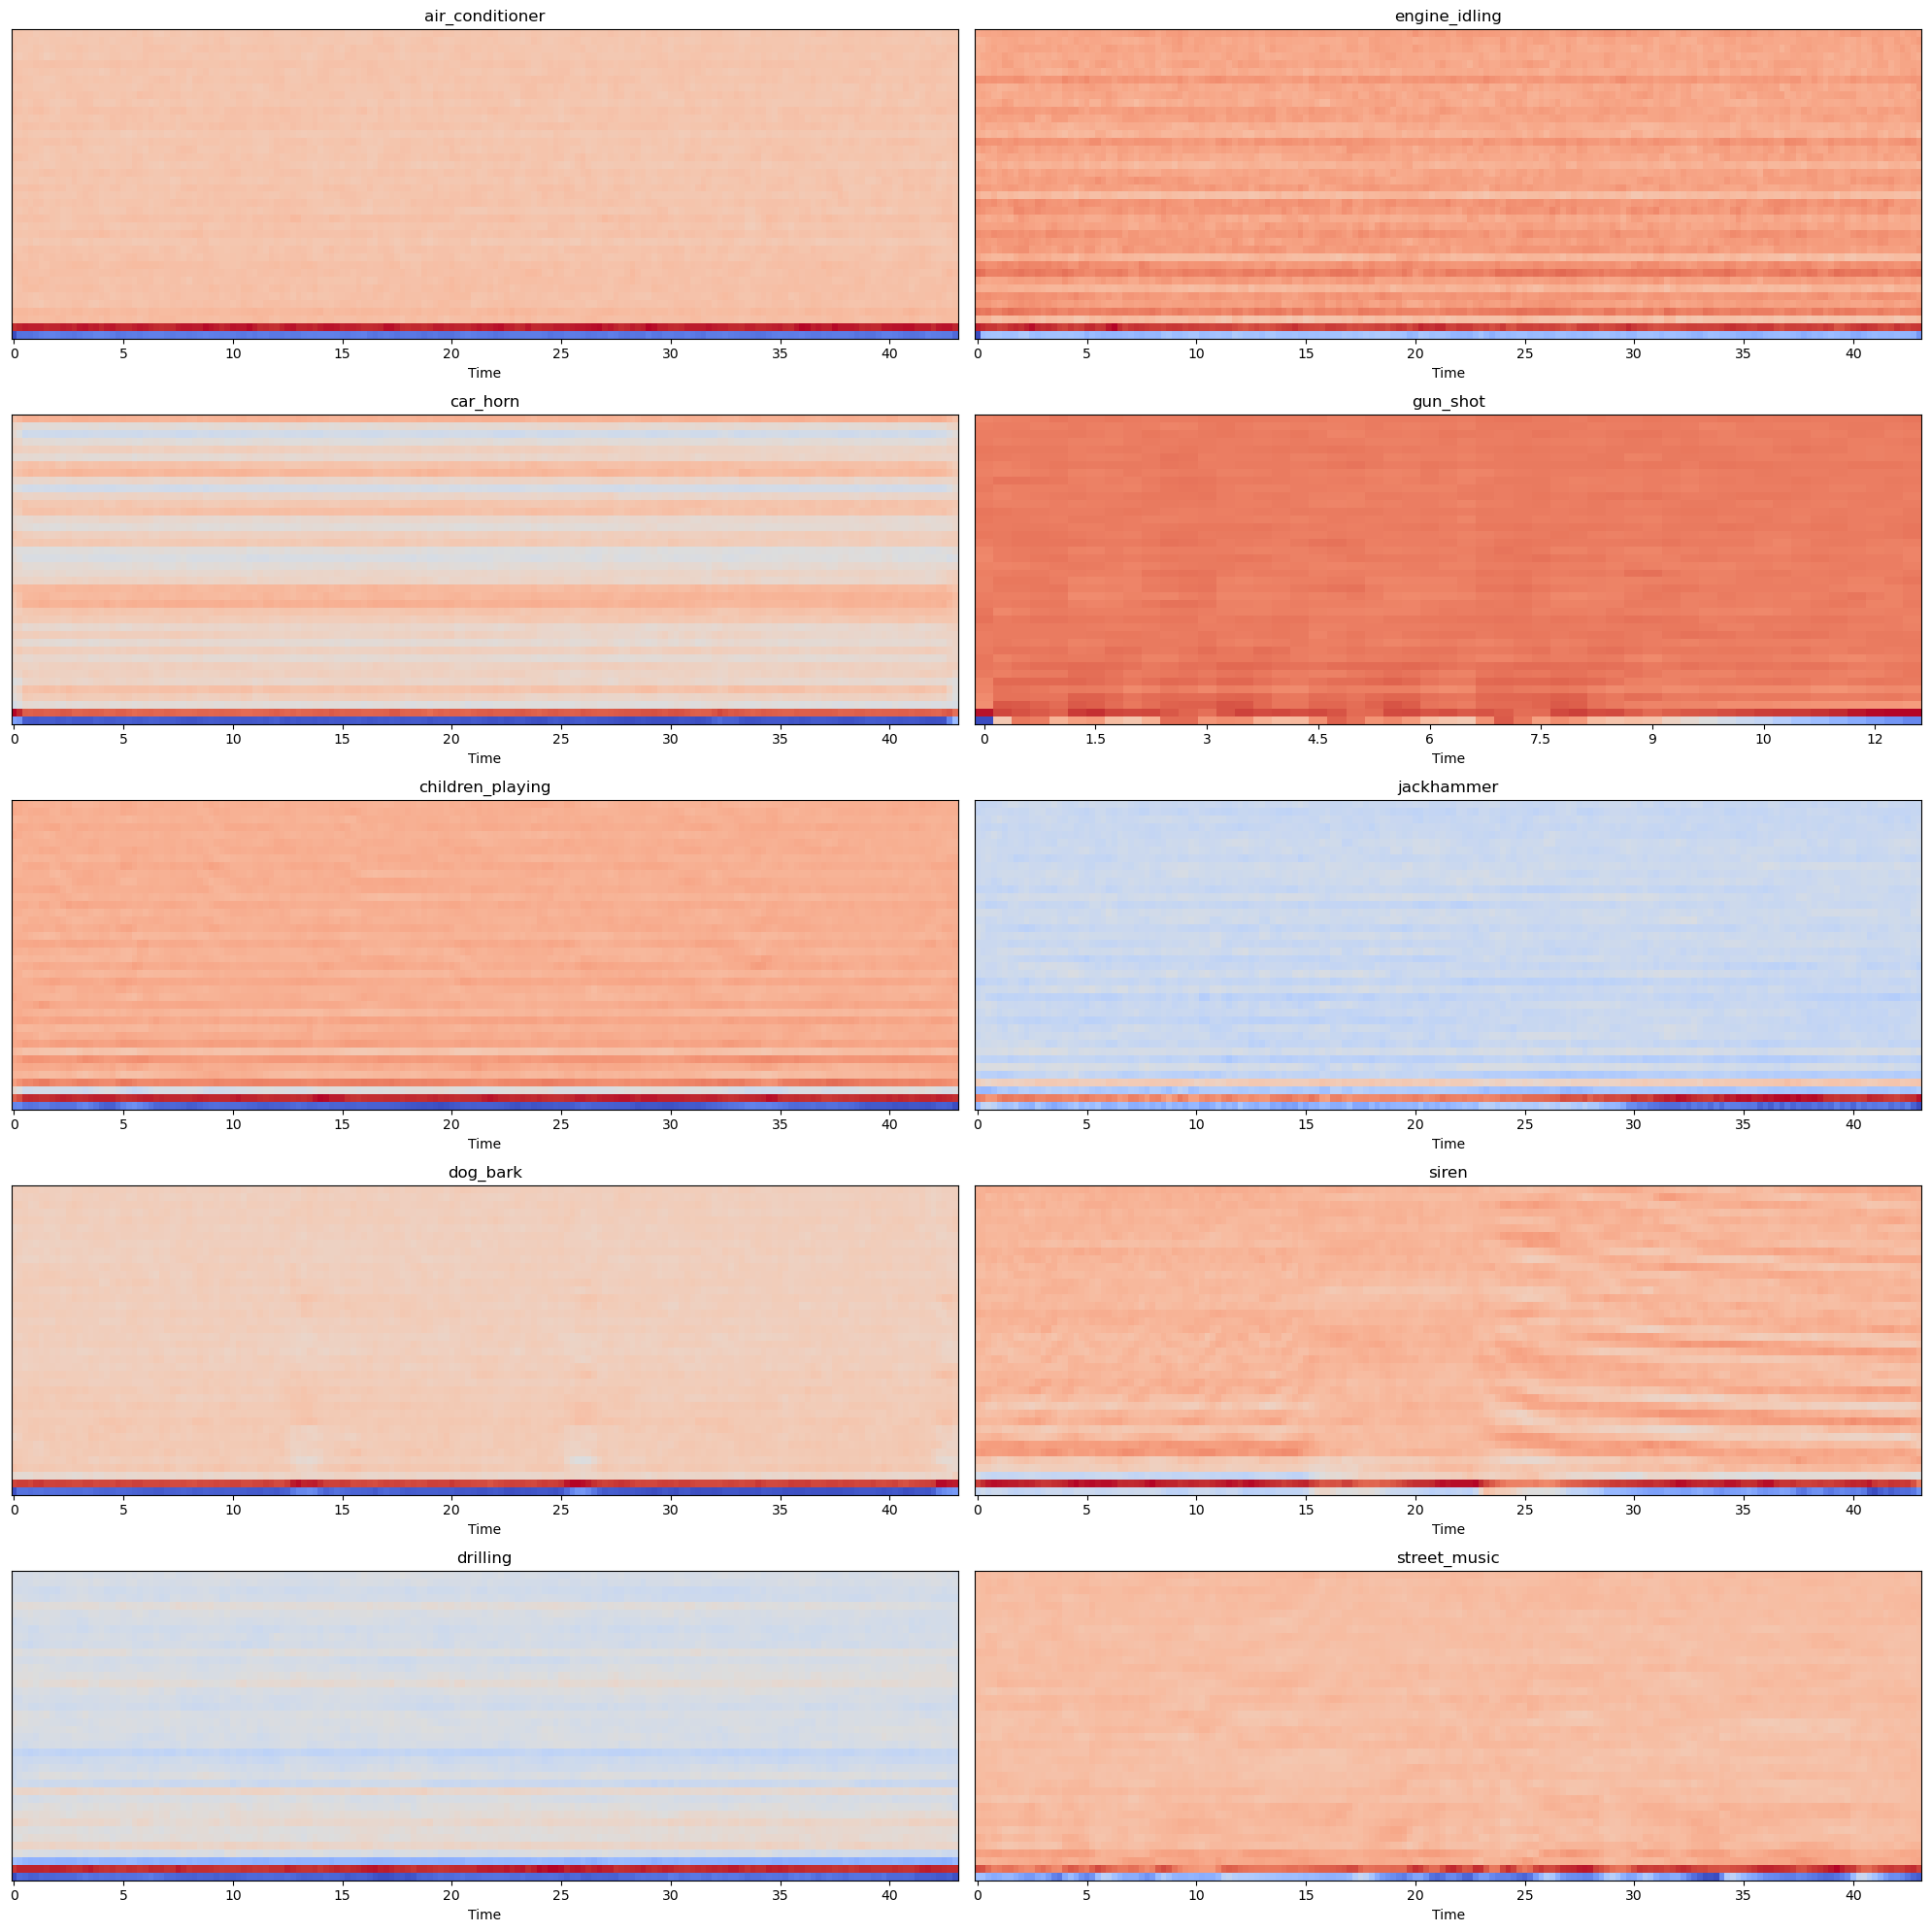

In [112]:
# Visualize 40 MFCCs
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mfccs = librosa.feature.mfcc(y=audio_file,
                                    sr=sample_rate, 
                                    n_fft=n_fft,
                                    n_mfcc=40)
        librosa.display.specshow(mfccs, 
                             sr=n_fft, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()
plt.savefig("mfcc_Dataset.png", bbox_inches="tight", dpi=800)

STFT (Short-Term Fourier Transform), Mel-Spectograms and MFCC (Mel-Frequency Cepstral Coefficients) are all popular ways to process audio signals and generate features as input for machine learning algorithms such as Convolutional Neural Networks.

After taking a look at the graphs for some different permutations, we can observe that the signals for the dataset classes are different enough to be classified correctly.

We will use a machine learning algorithm to process this data and classify the different audio files.

In [ ]:
!pip install tensorflow_hub
import tensorflow_hub as hub

In [ ]:
# Load the YAMNet model
model = hub.load('https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1')

def extract_features(file_path, max_length=40):
    signal, sr = librosa.load(file_path, sr=22050)
    audio = tf.convert_to_tensor(signal, dtype=tf.float32)
    scores, embeddings, log_mel_spectrogram = model(audio)
    # Pad or truncate the embeddings to ensure consistent length
    if len(embeddings) < max_length   
        embeddings = tf.pad(embeddings, [[0, max_length - len(embeddings)], [0, 0]])
    else:
        embeddings = embeddings[:max_length]
    
    return embeddings